In [117]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from tqdm import tqdm
import time


In [118]:
rootfolder = '.'

Load the image and rescale it in $[0,1]$

In [119]:
img = imread(f'data/cameraman.png') / 255
img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 5
h = p // 2

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12


Corrupt the image with white gaussian noise

In [120]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [121]:
psnr_noisy = 10 * np.log10(1/ np.square(np.subtract(img, noisy_img)).mean())


Text(0.5, 1.0, 'Noisy image, PSNR = 22.11')

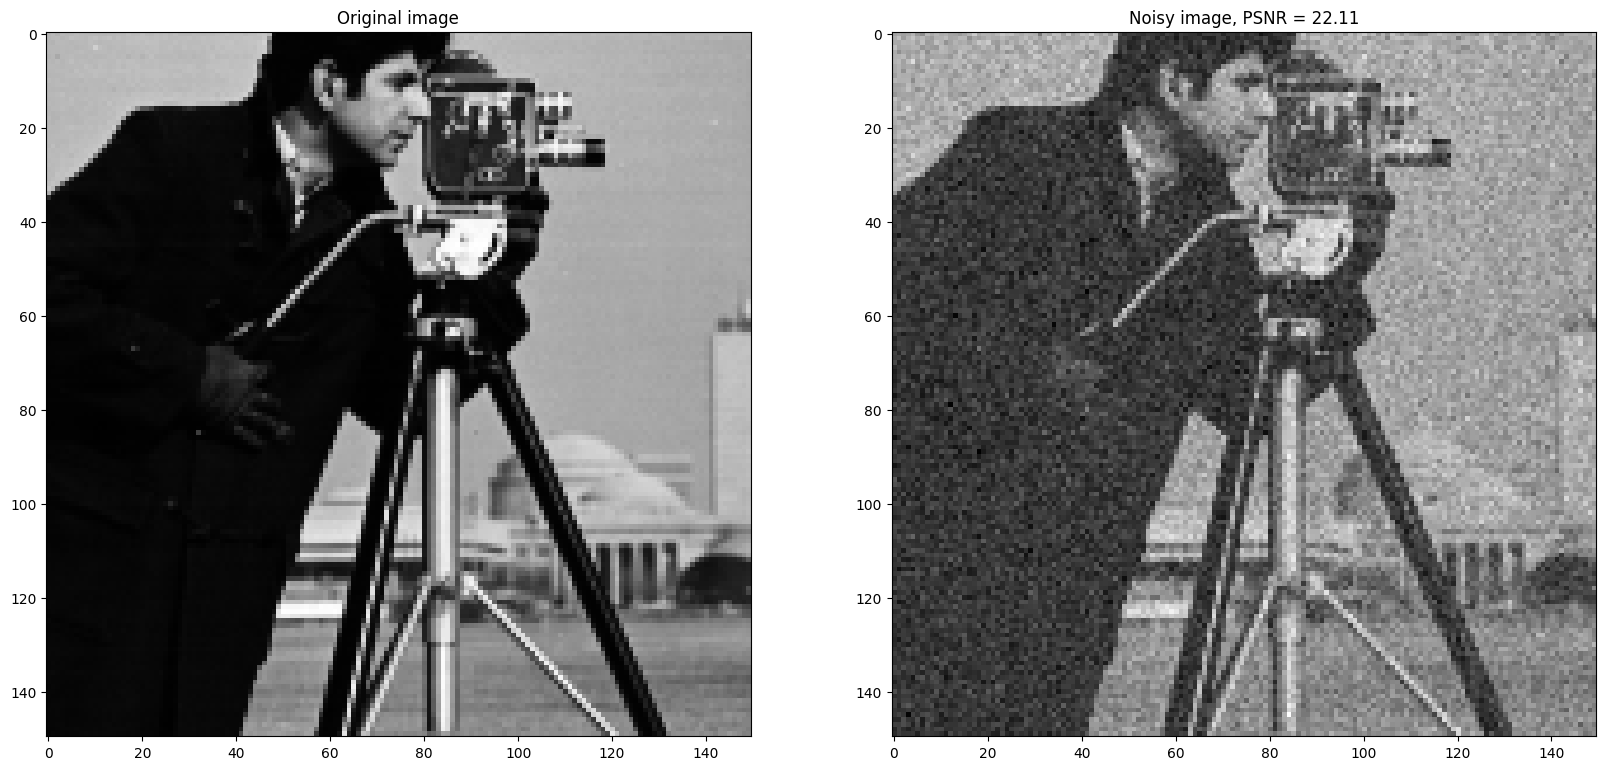

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

Text(0.5, 1.0, 'Image with patches')

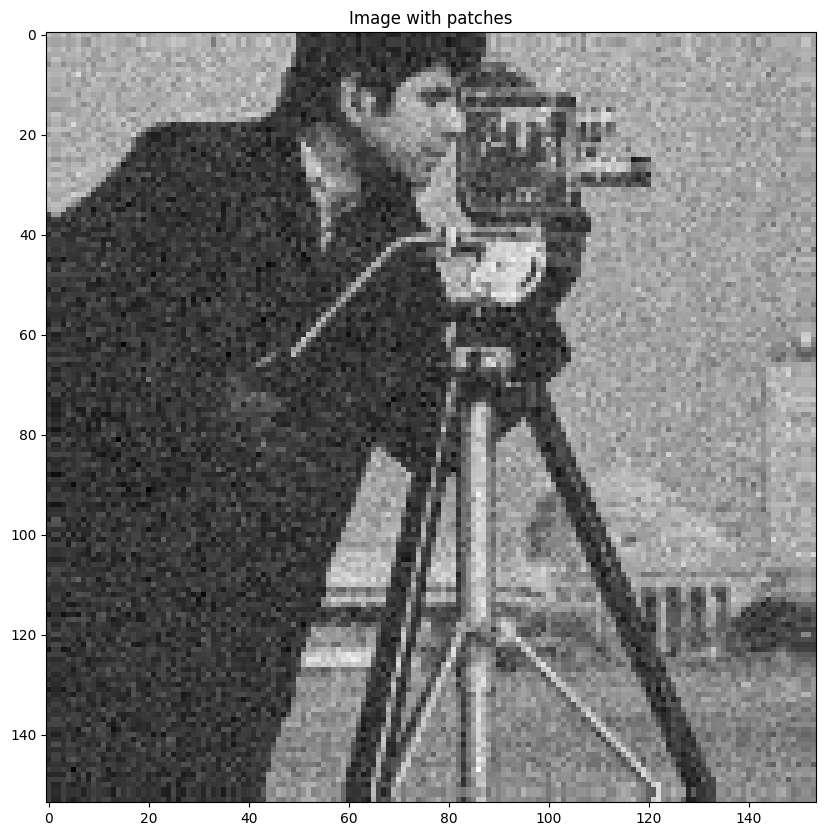

In [123]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, h, mode='symmetric')

plt.figure(figsize=(10, 10))
plt.imshow(img_pad, cmap='gray')
plt.title('Image with patches')


Main loop

In [124]:
for r in tqdm(range(0, imsz[0])):
    for c in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (r, c) in the noisy image
        s = img_pad[r:r+2*h, c:c+2*h]

        # initialize the pixel estimate and the total weights
        w = 0
        pixel_hat = 0 
        for i in range(-H, H+1):
            for j in range(-H, H+1):
                if r + i >= 0 and r + i <= imsz[0]  and c + j >= 0 and c + j <= imsz[1]: 
                    # extract the patch
                    z = img_pad[r+i:r+i+2*h, c+j:c+j+2*h]

                    # compute the distance with the reference patch
                    d = np.linalg.norm(s - z, 2)**2

                    # update the weight and the pixel estimate
                    weight = np.exp(-d / (M*sigma_noise**2))
                    pixel_hat += weight * z[h, h]
                    
                    w += weight

        # estimate the pixel (r, c) as the weighted average of the central pixel of the extracted patches
        img_hat[r, c] = pixel_hat / w

100%|██████████| 150/150 [05:31<00:00,  2.21s/it]


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 27.47')

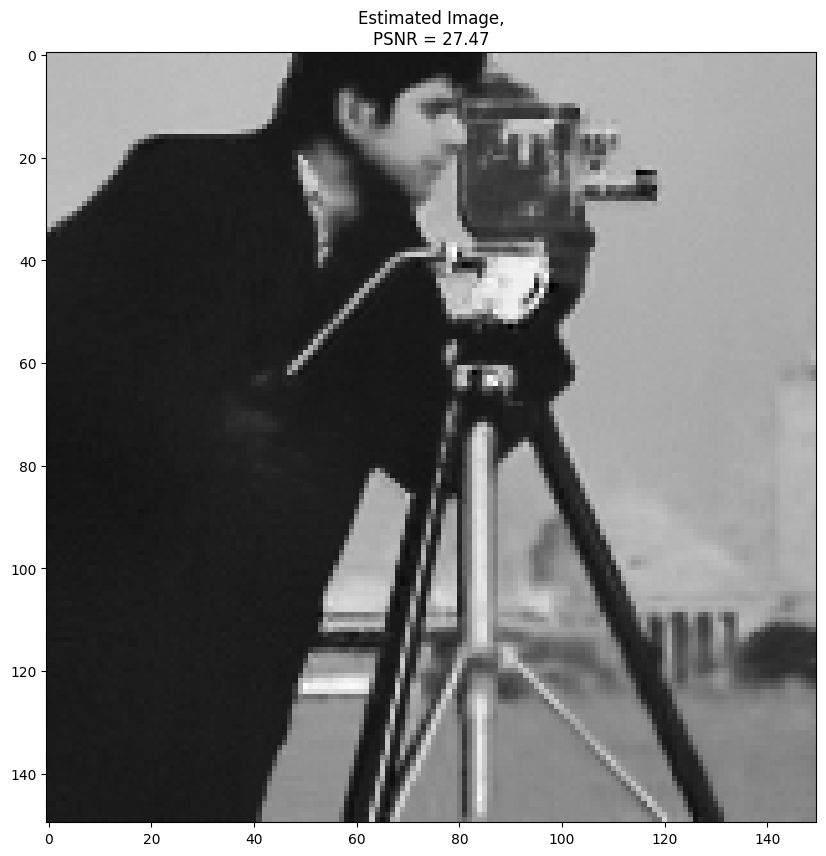

In [125]:
psnr_hat = 10*np.log10(1 / np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
